In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#workflow
!git clone https://github.com/nlp-chula/traffy-predict.git

Cloning into 'traffy-predict'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 199 (delta 26), reused 0 (delta 0), pack-reused 117
Receiving objects: 100% (199/199), 6.65 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 65.2 MB/s eta 0:00:00


In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 8.6 MB/s eta 0:00:00


In [ ]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

In [ ]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

In [ ]:
import pandas as pd
import numpy as np
import random
from pythainlp.tokenize import word_tokenize
import emoji
import re

In [ ]:
import math
import torch
import torch.nn as nn
import torchtext
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Start Data Collection and Exploring

In [ ]:
df_train = pd.read_csv("/content/traffy-predict/dataset/TF-checked-train-dataset-v2.csv")
print("Label Train : ",len(df_train["label"].value_counts()))

df_test = pd.read_csv("/content/traffy-predict/dataset/TF-checked-test-dataset-v2.csv")
print("Label Test : ",len(df_test["label"].value_counts()))

Label Train :  28
Label Test :  28


#Data Cleaning

In [ ]:
df_train = df_train.rename(columns={"label": "Category"})
df_test = df_test.rename(columns={"label": "Category"})

<BarContainer object of 28 artists>

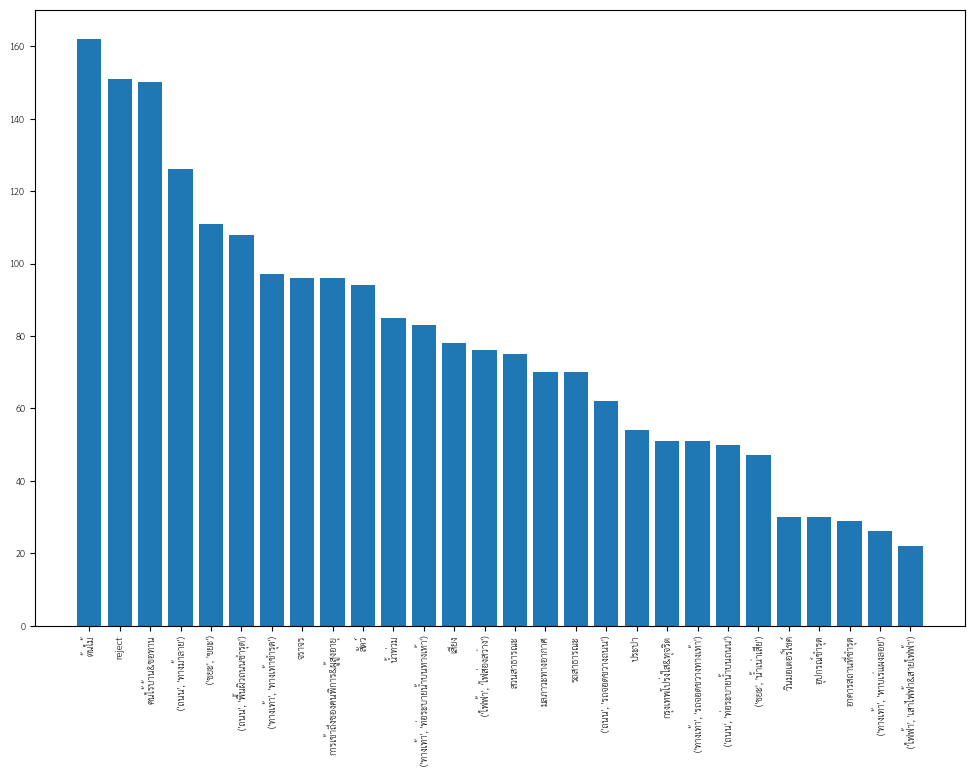

In [ ]:

plt.figure(figsize=(12, 8))
plt.xticks(rotation=90)
plt.bar(df_train["Category"].value_counts().index,df_train["Category"].value_counts().tolist())

<BarContainer object of 28 artists>

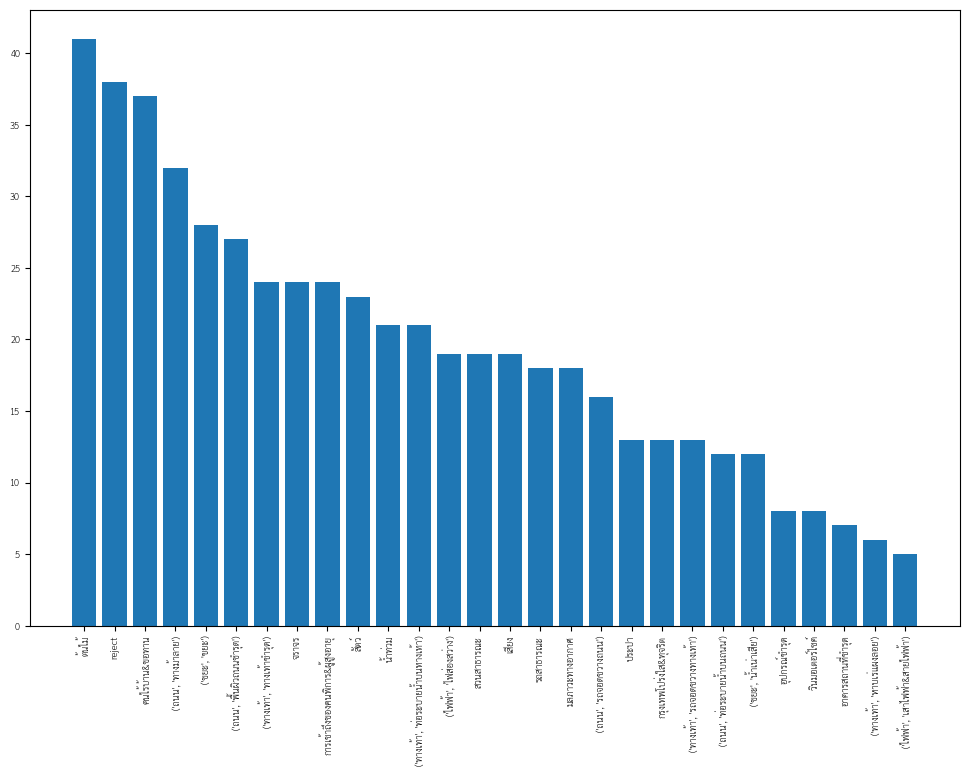

In [ ]:

plt.figure(figsize=(12, 8))
plt.xticks(rotation=90)
plt.bar(df_test["Category"].value_counts().index,df_test["Category"].value_counts().tolist())

In [ ]:
# Train
url_pattern = r'https?://\S+'

# Iterate over rows in DataFrame and remove URLs
for index, row in df_train.iterrows():
    urls = re.findall(url_pattern, row['description'])
    for url in urls:
        print(f"Found URL '{url}' in '{row['description']}'")
        # Replace the URL with an empty string
        row['description'] = row['description'].replace(url, '')

# Now, drop rows where the description becomes empty after removing URLs
indexes_to_drop = df_train[df_train['description'] == ''].index
df_train = df_train.drop(indexes_to_drop)

Found URL 'https://goo.gl/maps/2PHKzwWhqpLRnaqu8' in 'Freesia Saladaeng Silom Apartments 02 636 3856 https://goo.gl/maps/2PHKzwWhqpLRnaqu8'
Found URL 'https://maps.app.goo.gl/NELkRqB9JLqUmPjX7' in '18 ซอย เอกชัย 76 https://maps.app.goo.gl/NELkRqB9JLqUmPjX7'
Found URL 'https://www.google.co.th/maps/@13.6890571,100.4008629,18.75z?hl=th&authuser=0' in 'https://www.google.co.th/maps/@13.6890571,100.4008629,18.75z?hl=th&authuser=0'
Found URL 'https://goo.gl/maps/xkhNwW4RbkwyS4JQ6' in 'Soi Vibhavadi Rangsit 60, Lane 16 https://goo.gl/maps/xkhNwW4RbkwyS4JQ6'
Found URL 'https://maps.app.goo.gl/hpDT1PbhkZn1mRLD7' in 'แขวง หนองค้างพลู แขวง หนองค้างพลู เขตหนองแขม กรุงเทพมหานคร 10160 https://maps.app.goo.gl/hpDT1PbhkZn1mRLD7'
Found URL 'https://maps.app.goo.gl/4vVxVaEPAvFwPhph8' in 'ปักหมุด https://maps.app.goo.gl/4vVxVaEPAvFwPhph8'
Found URL 'https://maps.app.goo.gl/YszLnuWr7rrFpcEv6' in '99 ลาดพร้าว https://maps.app.goo.gl/YszLnuWr7rrFpcEv6'
Found URL 'https://www.matichon.co.th/local/quality-li

In [ ]:
# Test
url_pattern = r'https?://\S+'

# Iterate over rows in DataFrame and remove URLs
for index, row in df_test.iterrows():
    urls = re.findall(url_pattern, row['description'])
    for url in urls:
        print(f"Found URL '{url}' in '{row['description']}'")
        # Replace the URL with an empty string
        row['description'] = row['description'].replace(url, '')

# Now, drop rows where the description becomes empty after removing URLs
indexes_to_drop = df_test[df_test['description'] == ''].index
df_test = df_test.drop(indexes_to_drop)

Found URL 'https://goo.gl/maps/t6mQL9TNMDNZSs5N8' in 'https://goo.gl/maps/t6mQL9TNMDNZSs5N8'
Found URL 'https://www.google.com/maps/place/26+Lat+Phrao+Wang+Hin+68+Alley,+Khwaeng+Lat+Phrao,+Khet+Lat+Phrao,+Krung+Thep+Maha+Nakhon+10230/@13.8269654,100.5929107,16z/data=!4m2!3m1!1s0x30e29d0bc8028937:0x7371e7bc84fd4415?hl=en-TH&gl=th' in 'https://www.google.com/maps/place/26+Lat+Phrao+Wang+Hin+68+Alley,+Khwaeng+Lat+Phrao,+Khet+Lat+Phrao,+Krung+Thep+Maha+Nakhon+10230/@13.8269654,100.5929107,16z/data=!4m2!3m1!1s0x30e29d0bc8028937:0x7371e7bc84fd4415?hl=en-TH&gl=th'
Found URL 'https://goo.gl/maps/oUhznF3Nu5WKLpR3A' in 'https://goo.gl/maps/oUhznF3Nu5WKLpR3A'


In [ ]:
print(df_train.count())

description    2175
Category       2175
dtype: int64


In [ ]:
print(df_test.count())

description    543
Category       543
dtype: int64


In [ ]:
labels = df_train["Category"].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label)

id2label_json = json.dumps(id2label, ensure_ascii=False)
with open('idx2lab.json', 'w') as json_file:
    json_file.write(id2label_json)

{0: "('ถนน', 'ท่อระบายน้ำบนถนน')", 1: 'จราจร', 2: "('ถนน', 'พื้นผิวถนนชำรุด')", 3: 'กรุงเทพโปร่งใส&ทุจริต', 4: 'ต้นไม้', 5: 'คนไร้บ้าน&ขอทาน', 6: "('ทางเท้า', 'ท่อระบายน้ำบนทางเท้า')", 7: 'reject', 8: "('ถนน', 'ทางม้าลาย')", 9: "('ทางเท้า', 'ทางเท้าชำรุด')", 10: "('ขยะ', 'ขยะ')", 11: 'น้ำท่วม', 12: 'ประปา', 13: 'สวนสาธารณะ', 14: 'สัตว์', 15: 'มลภาวะทางอากาศ', 16: "('ทางเท้า', 'รถจอดขวางทางเท้า')", 17: 'การเข้าถึงของคนพิการ&ผู้สูงอายุ', 18: 'เสียง', 19: "('ไฟฟ้า', 'ไฟส่องสว่าง')", 20: 'อาคารสถานที่ชำรุด', 21: "('ขยะ', 'น้ำเน่าเสีย')", 22: "('ไฟฟ้า', 'เสาไฟฟ้า&สายไฟฟ้า')", 23: "('ถนน', 'รถจอดขวางถนน')", 24: 'รถสาธารณะ', 25: "('ทางเท้า', 'หาบเร่แผงลอย')", 26: 'วินมอเตอร์ไซค์', 27: 'อุปกรณ์ชำรุด'}


In [ ]:
tokenizer = word_tokenize

In [ ]:
class TextIter(torch.utils.data.Dataset):
    def __init__(self, input_data):
        self.text = input_data['description'].values.tolist()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return self.text[idx]



def tokenizer(text):
    # Remove emojis
    text_no_emoji = emoji.demojize(text)
    tokens = word_tokenize(text_no_emoji)
    return tokens

# Build vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

data_iter = TextIter(df_train)
vocab = build_vocab_from_iterator(yield_tokens(data_iter), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
# Convert vocab to JSON
vocab_json_object = json.dumps(vocab.get_stoi())  # Convert the token_to_id dictionary to a JSON string
with open("token2idx.json", "w") as outfile:
    outfile.write(vocab_json_object)  # Write the JSON string to the file

In [ ]:
print(vocab.get_stoi())
print(len(vocab))

{'๗': 4906, '๕๐': 4905, '๕': 4904, '๒๐': 4902, '่': 4898, 'ไอติม': 4892, 'ไหม้': 4889, 'ไล่ที่': 4887, 'ไลน์': 4885, 'ไม๊': 4882, 'ไม้ไล่': 4881, 'ไม้แขวนเสื้อ': 4880, 'ไม้หน้า': 4879, 'ไม่เท่าไหร่': 4875, 'ไมโครโฟน': 4873, 'ไฟ้า': 4872, 'ไฟสัญญาณจราจร': 4870, 'ไปนอก': 4866, 'ไทร': 4863, 'ไถ': 4861, 'ได้รูป': 4858, 'ได้การ': 4856, 'ไชย': 4854, 'ไค่': 4853, 'ไข้เลือดออก': 4852, 'ไก': 4848, 'ให้ได้': 4847, 'ให้ความสำคัญ': 4842, 'ใมห่': 4836, 'ใบเสร็จ': 4835, 'ในกรณีที่': 4831, 'ใช้ไม่ได้': 4828, 'ใจดี': 4824, 'โอกาส': 4816, 'โลก': 4808, 'โรย': 4807, 'โรงเรียนหญิง': 4806, 'โย': 4803, 'โม่': 4802, 'โม': 4801, 'โพส': 4799, 'โพธิ์ทอง': 4798, 'โปร่งใส': 4797, 'โท': 4790, 'โถ': 4789, 'โดยไม่จำเป็น': 4788, 'โดยที่': 4785, 'โชย': 4781, 'โฆษณา': 4779, 'โค่นล้ม': 4778, 'โคมไฟ': 4777, 'โกลเด้น': 4775, 'โกมล': 4774, 'แออัด': 4771, 'แอพ': 4769, 'แอบดู': 4768, 'แสบตา': 4759, 'แสบ': 4758, 'แว้': 4754, 'แวก': 4752, 'แล้ง': 4750, 'แระ': 4749, 'แรงลม': 4748, 'แรงงานเด็ก': 4747, 'ให้เช่า': 4846, 'แยะ': 474

In [ ]:
print(vocab.get_itos())
vocab.get_itos()[12]

['<pad>', '<unk>', ' ', 'มี', 'ไม่', 'ค่ะ', 'มา', 'และ', 'ที่', 'ถนน', 'ให้', 'ครับ', 'ซอย', 'ใน', 'มาก', 'คน', 'การ', 'เป็น', 'รถ', 'ได้', 'ไป', 'แล้ว', 'บริเวณ', '  ', 'แจ้ง', 'จะ', 'บ้าน', 'ทำให้', 'เขต', 'บน', 'จอด', 'ขยะ', 'ทางเท้า', 'เลย', '1', 'อยาก', 'ก็', '.', 'อยู่', 'หน้า', 'ของ', 'เรื่อง', 'แต่', '2', 'ทาง', 'ด้วย', 'ท่อ', 'ต้นไม้', 'เดิน', 'ว่า', 'ทางม้าลาย', 'คลอง', 'ตรง', 'ปัญหา', 'แยก', 'ต้อง', 'ทำ', 'เวลา', 'ไฟ', 'นี้', 'ฝา', 'ช่วย', 'ยัง', 'ๆ', 'กับ', ')', 'จาก', '(', 'ข้าม', 'น้ำ', 'รบกวน', 'บาง', '-', 'ชำรุด', 'เพราะ', 'แก้ไข', 'ติด', 'ป้ายรถเมล์', 'จุด', 'พื้นที่', 'หลาย', 'อันตราย', 'หรือ', 'เข้า', 'ทั้ง', 'ฝั่ง', 'เยอะ', 'น้ำท่วม', '3', 'ผู้', 'เข้ามา', 'ใช้', 'ข้ามถนน', 'ร้าน', 'สามารถ', 'ท่อระบายน้ำ', 'สะพาน', 'ขอ', 'สวน', 'ขึ้น', 'ตัด', 'ไร้', 'ทางเดิน', 'คนแก่', 'นาน', 'เกิด', 'ช่วง', 'สวนสาธารณะ', 'วัน', 'ถึง', 'เหม็น', 'คะ', 'ทิ้ง', 'ปี', 'สะพานลอย', 'เก็บ', 'กีดขวาง', 'ข้าง', 'ต่อ', 'ลง', 'เคย', 'เด็ก', 'พื้น', 'ทุกวัน', 'หลุม', 'เสียงดัง', 'กัน', 'ปากซอย'

In [ ]:
text = 'การจราจรจากบางกะปิ๗'
seq = [vocab[word] for word in tokenizer(text)]
print(tokenizer(text))
print(seq)
x = [vocab.get_itos()[i] for i in seq]
x

['การจราจร', 'จาก', 'บาง', 'กะปิ', '๗']

['การจราจร', 'จาก', 'บาง', 'กะปิ', '๗']
[294, 66, 71, 446, 4906]


#Model

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

In [ ]:
hidden_size = 300

input_data = torch.LongTensor(seq).unsqueeze(0)
print(input_data)
emb_model = Embeddings(hidden_size, len(vocab))
token_emb = emb_model(input_data)
print(f'Size of token embedding: {token_emb.size()}')
print(token_emb)



tensor([[ 294,   66,   71,  446, 4906]])
Size of token embedding: torch.Size([1, 5, 300])
tensor([[[ -4.3002,  24.2907, -22.7077,  ...,   7.5084,   3.3054,  13.7805],
         [-13.2934,  -9.9280,  -8.7727,  ...,  27.4199,  -5.9531,   4.8620],
         [-15.8915,   7.5914,   1.3760,  ..., -18.8377,  14.1848,  24.6041],
         [ 15.6313,  17.8549,  -3.0993,  ...,   7.6155,   8.1755, -22.8789],
         [  8.9117,  13.4749, -10.6427,  ...,   9.9591,  -7.2623,  -9.8165]]],
       grad_fn=<MulBackward0>)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [ ]:
pe_model = PositionalEncoding(d_model=300, vocab_size=len(vocab))
output_pe = pe_model(token_emb)
print(output_pe)
print(f'Size of output embedding: {output_pe.size()}')

tensor([[[ -4.7780,  28.1008, -25.2307,  ...,   9.4538,   3.6726,  16.4228],
         [-13.8355, -10.4307,  -8.8498,  ...,  31.5777,  -6.6144,   6.5134],
         [-16.6468,   7.9726,   2.5870,  ..., -19.8196,  15.7611,  28.4490],
         [ 17.5249,  18.7388,  -3.0938,  ...,   9.5728,   9.0842,  -0.0000],
         [  9.0610,  14.2458, -12.4710,  ...,  12.1767,  -8.0688,  -9.7961]]],
       grad_fn=<MulBackward0>)
Size of output embedding: torch.Size([1, 5, 300])


In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, d_head_size):
        super().__init__()
        self.lin_key = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_query = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_value = nn.Linear(d_model, d_head_size, bias=False)
        self.d_model = d_model

    def forward(self, x):
        query = self.lin_query(x)
        key = self.lin_key(x)
        value = self.lin_value(x)

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_model)
        p_attn = scores.softmax(dim=-1)
        x = torch.matmul(p_attn, value)

        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        d_k = d_model // h
        self.multi_head = nn.ModuleList([SingleHeadAttention(d_model, d_k) for _ in range(h)])
        self.lin_agg = nn.Linear(d_model, d_model)

    def forward(self, x):
        x = torch.cat([head(x) for head in self.multi_head], dim=-1)
        return self.lin_agg(x)

In [ ]:
mult_att = MultiHeadAttention(h=2, d_model=300)
output_mult_att = mult_att(output_pe)
print(output_mult_att)
print(f'Size of output embedding after multi-head attention: {output_mult_att.size()}')


tensor([[[-1.5303,  4.4460,  2.6618,  ...,  0.5373,  6.0923,  1.4246],
         [-3.1969, -5.8383, -3.7560,  ..., -7.2769, -1.4952, -4.3364],
         [-3.1969, -5.8383, -3.7560,  ..., -7.2769, -1.4952, -4.3364],
         [10.2037, -2.9065,  1.2160,  ...,  0.6121, -6.9271, -3.0173],
         [ 7.8443, -1.2062, -1.8028,  ..., -7.5170, -1.6879, -5.7287]]],
       grad_fn=<ViewBackward0>)
Size of output embedding after multi-head attention: torch.Size([1, 5, 300])


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(d_model))
        self.b_2 = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class ResidualConnection(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1, x2):
        return self.dropout(self.norm(x1 + x2))

In [ ]:
res_conn_1 = ResidualConnection(d_model=300)
output_res_conn_1 = res_conn_1(output_pe, output_mult_att)
print(output_res_conn_1)
print(f'Size of output embedding after residual connection: {output_res_conn_1.size()}')


tensor([[[-0.3705,  1.8206, -1.2875,  ...,  0.5486,  0.5359,  0.9917],
         [-0.9206, -0.8746, -0.6539,  ...,  1.5703, -0.3829,  0.0000],
         [-1.1785,  0.1972, -0.0096,  ..., -1.6325,  0.9565,  0.0000],
         [ 1.5133,  0.8163, -0.2215,  ...,  0.4853,  0.0149, -0.2883],
         [ 0.9269,  0.7028, -0.8803,  ...,  0.2171, -0.6185, -0.9528]]],
       grad_fn=<MulBackward0>)
Size of output embedding after residual connection: torch.Size([1, 5, 300])


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [ ]:
ff = FeedForward(d_model=300, d_ff=12)
output_ff = ff(output_res_conn_1)
print(output_ff)
print(f'Size of output embedding after feed-forward network: {output_ff.size()}')


tensor([[[-0.0556, -0.0072,  0.1291,  ..., -0.4302, -0.0642, -0.2276],
         [ 0.0218,  0.1006,  0.2869,  ..., -0.2479, -0.2672, -0.2179],
         [ 0.1026,  0.1062,  0.3227,  ...,  0.0887, -0.2675, -0.2461],
         [ 0.0188,  0.1317, -0.1729,  ..., -0.1271, -0.1142, -0.0341],
         [ 0.3543,  0.1171,  0.1022,  ..., -0.3460, -0.3263, -0.2425]]],
       grad_fn=<ViewBackward0>)
Size of output embedding after feed-forward network: torch.Size([1, 5, 300])


In [ ]:
res_conn_2 = ResidualConnection(d_model=300)
output_res_conn_2 = res_conn_2(output_res_conn_1, output_ff)
print(output_res_conn_2)
print(f'Size of output embedding after second residual: {output_res_conn_2.size()}')

tensor([[[-0.4581,  1.8200, -1.2031,  ...,  0.0958,  0.4551,  0.7525],
         [-0.9189, -0.7895, -0.3672,  ...,  1.3855, -0.0000, -0.2125],
         [-0.0000,  0.3149,  0.3251,  ..., -1.6176,  0.7184, -0.2600],
         [ 1.5881,  0.9862, -0.3967,  ...,  0.3787, -0.0927, -0.3224],
         [ 1.2906,  0.0000, -0.7847,  ..., -0.1305, -0.9528, -1.2053]]],
       grad_fn=<MulBackward0>)
Size of output embedding after second residual: torch.Size([1, 5, 300])


In [ ]:
class SingleEncoder(nn.Module):
    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.res_1 = ResidualConnection(d_model, dropout)
        self.res_2 = ResidualConnection(d_model, dropout)

        self.d_model = d_model

    def forward(self, x):
        x_attn = self.self_attn(x)
        x_res_1 = self.res_1(x, x_attn)
        x_ff = self.feed_forward(x_res_1)
        x_res_2 = self.res_2(x_res_1, x_ff)

        return x_res_2

In [ ]:
class EncoderBlocks(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(N)])
        self.norm = LayerNorm(layer.d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [ ]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, d_ff, N,
                dropout=0.1):
        super().__init__()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = Embeddings(d_model, vocab_size)
        self.pos_encoder = PositionalEncoding(d_model=d_model, vocab_size=vocab_size)

        attn = MultiHeadAttention(nhead, d_model)
        ff = FeedForward(d_model, d_ff, dropout)
        self.transformer_encoder = EncoderBlocks(SingleEncoder(d_model, attn, ff, dropout), N)
        self.classifier = nn.Linear(d_model, 28)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

model = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50,
                                    N=6, dropout=0.1).to(device)



In [ ]:
class TextDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):
      self.text = input_data['description'].values.tolist()
      self.label = [int(label2id[i]) for i in input_data['Category'].values.tolist()]

  def __len__(self):
      return len(self.label)

  def get_sequence_token(self, idx):
      sequence = [vocab[word] for word in tokenizer(self.text[idx])]
      len_seq = len(sequence)
      return sequence, len_seq

  def get_labels(self, idx):
      return self.label[idx]

  def __getitem__(self, idx):
      sequence, len_seq = self.get_sequence_token(idx)
      label = self.get_labels(idx)
      return sequence, label, len_seq

def collate_fn(batch):

    sequences, labels, lengths = zip(*batch)
    max_len = max(lengths)

    for i in range(len(batch)):
        if len(sequences[i]) != max_len:
          for j in range(len(sequences[i]),max_len):
            sequences[i].append(0)

    return torch.tensor(sequences, dtype=torch.long), torch.tensor(labels, dtype=torch.long)

In [ ]:
def train(model, dataset, epochs, lr, bs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=lr)
    train_dataset = TextDataset(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, collate_fn=collate_fn, shuffle=True)
    best_loss = float('inf')  # Initialize with a very high value
    loss_hist = []
    acc_hist = []
    for epoch in range(epochs):
        total_loss_train = 0
        total_acc_train = 0
        for train_sequence, train_label in tqdm(train_dataloader):
            predictions = model(train_sequence.to(device))
            labels = train_label.to(device)
            loss = criterion(predictions, labels)


            correct = predictions.argmax(axis=1) == labels
            acc = correct.sum().item() / correct.size(0)
            total_acc_train += correct.sum().item()
            total_loss_train += loss.item()


            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        avg_loss_train = total_loss_train / len(train_dataset)
        avg_acc_train = total_acc_train / len(train_dataset)

        loss_hist.append(avg_loss_train)
        acc_hist.append(avg_acc_train)

        print(f'Epochs: {epoch + 1} | Loss: {avg_loss_train:.3f} | Accuracy: {avg_acc_train:.3f}')
        # Save model if the current loss is better than the best loss
        if avg_loss_train < best_loss:
            best_loss = avg_loss_train
            torch.save(model.state_dict(), 'Model.pt')
            print("Model saved.")

    return loss_hist, acc_hist

# Train the model and get the training history


In [ ]:
epochs = 20
lr = 1e-4
batch_size = 1
loss_history, acc_history = train(model, df_train, epochs, lr, batch_size)

100%|██████████| 2175/2175 [01:15<00:00, 28.96it/s]


Epochs: 1 | Loss: 1.837 | Accuracy: 0.503
Model saved.


100%|██████████| 2175/2175 [01:14<00:00, 29.01it/s]


Epochs: 2 | Loss: 1.452 | Accuracy: 0.623
Model saved.


100%|██████████| 2175/2175 [01:16<00:00, 28.43it/s]


Epochs: 3 | Loss: 1.297 | Accuracy: 0.694
Model saved.


100%|██████████| 2175/2175 [01:17<00:00, 28.01it/s]


Epochs: 4 | Loss: 1.226 | Accuracy: 0.734
Model saved.


100%|██████████| 2175/2175 [01:16<00:00, 28.38it/s]


Epochs: 5 | Loss: 1.130 | Accuracy: 0.761
Model saved.


100%|██████████| 2175/2175 [01:15<00:00, 28.64it/s]


Epochs: 6 | Loss: 1.128 | Accuracy: 0.771
Model saved.


100%|██████████| 2175/2175 [01:15<00:00, 28.97it/s]


Epochs: 7 | Loss: 1.115 | Accuracy: 0.787
Model saved.


100%|██████████| 2175/2175 [01:14<00:00, 29.16it/s]


Epochs: 8 | Loss: 1.061 | Accuracy: 0.797
Model saved.


100%|██████████| 2175/2175 [01:14<00:00, 29.01it/s]


Epochs: 9 | Loss: 0.994 | Accuracy: 0.823
Model saved.


100%|██████████| 2175/2175 [01:15<00:00, 28.84it/s]


Epochs: 10 | Loss: 1.015 | Accuracy: 0.818


100%|██████████| 2175/2175 [01:14<00:00, 29.18it/s]


Epochs: 11 | Loss: 1.011 | Accuracy: 0.824


100%|██████████| 2175/2175 [01:14<00:00, 29.02it/s]


Epochs: 12 | Loss: 1.020 | Accuracy: 0.832


100%|██████████| 2175/2175 [01:14<00:00, 29.14it/s]


Epochs: 13 | Loss: 1.030 | Accuracy: 0.825


100%|██████████| 2175/2175 [01:14<00:00, 29.17it/s]


Epochs: 14 | Loss: 0.936 | Accuracy: 0.846
Model saved.


100%|██████████| 2175/2175 [01:14<00:00, 29.12it/s]


Epochs: 15 | Loss: 0.939 | Accuracy: 0.846


100%|██████████| 2175/2175 [01:14<00:00, 29.12it/s]


Epochs: 16 | Loss: 0.775 | Accuracy: 0.863
Model saved.


100%|██████████| 2175/2175 [01:15<00:00, 28.93it/s]


Epochs: 17 | Loss: 0.906 | Accuracy: 0.852


100%|██████████| 2175/2175 [01:14<00:00, 29.27it/s]


Epochs: 18 | Loss: 0.907 | Accuracy: 0.855


100%|██████████| 2175/2175 [01:15<00:00, 28.89it/s]


Epochs: 19 | Loss: 0.896 | Accuracy: 0.857


100%|██████████| 2175/2175 [01:15<00:00, 28.94it/s]

Epochs: 20 | Loss: 0.821 | Accuracy: 0.863


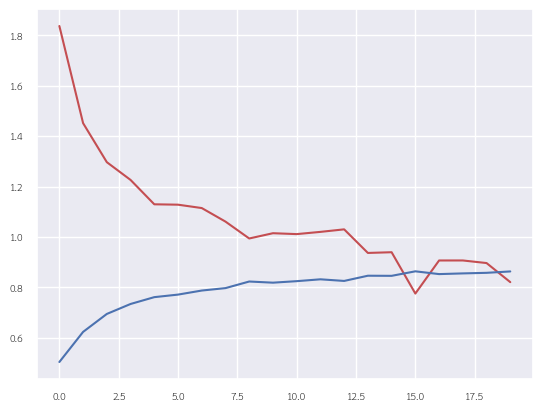

In [ ]:
plt.plot(loss_history,'r')
plt.plot(acc_history,'b')

# แสดงผลลัพธ์การทดสอบ

In [ ]:
model_state_dict = torch.load('Model.pt')
#model_state_dict = torch.load('Model.pt', map_location=torch.device('cpu'))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.25      0.42      0.31        12
           1       0.33      0.33      0.33        24
           2       0.69      0.33      0.45        27
           3       0.50      0.46      0.48        13
           4       0.90      0.88      0.89        41
           5       0.95      0.95      0.95        37
           6       0.67      0.95      0.78        21
           7       0.73      0.23      0.35        35
           8       0.82      1.00      0.90        32
           9       0.57      0.54      0.55        24
          10       0.67      0.71      0.69        28
          11       0.54      0.67      0.60        21
          12       0.50      0.38      0.43        13
          13       0.85      0.89      0.87        19
          14       1.00      0.70      0.82        23
          15       0.48      0.67      0.56        18
          16       0.50      0.92      0.65        13
          17       1.00    

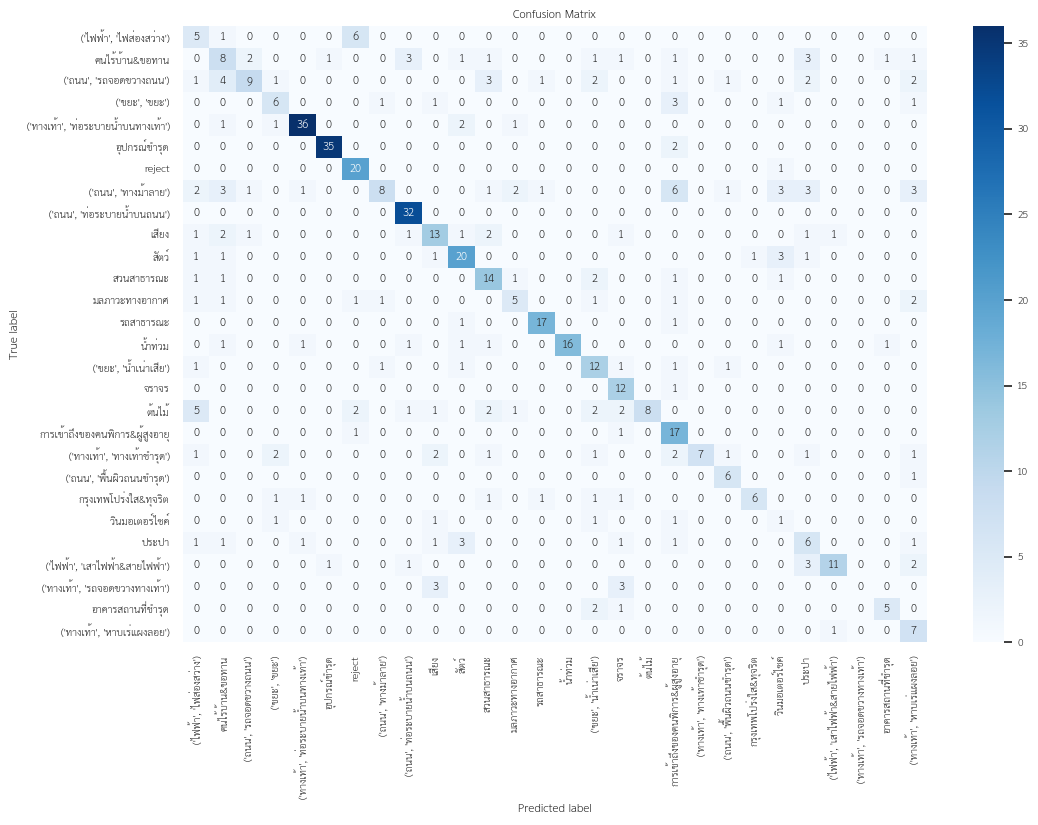

In [ ]:
def test(model_state_dict, dataloader, device):
    # Load the state dictionary into the model
    model.load_state_dict(model_state_dict)

    # Set the model to evaluation mode
    model.eval()

    predictions = []
    targets = []
    with torch.no_grad():
        for test_sequence, test_label in dataloader:
            # Move input data to the same device as the model
            test_sequence = test_sequence.to(device)
            # Perform inference
            output = model(test_sequence)
            # Convert the output to class labels
            predicted_labels = output.argmax(dim=1).cpu().numpy()
            # Append predictions and targets
            predictions.extend(predicted_labels)
            targets.extend(test_label.numpy())

    # Calculate classification report
    report = classification_report(targets, predictions)
    conf_matrix = confusion_matrix(targets, predictions)
    print(report)
    #print(conf_matrix)
    sns.set(font_scale=1.2)  # Adjust font scale for better readability
    sns.set(font='TH Sarabun Chula')
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=df_test["Category"].unique(),
                yticklabels=df_test["Category"].unique())
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
# Define the device
device = torch.device("cuda:0")  # or "cuda:0" if you want to use GPU

# Create DataLoader for the testing dataset
test_dataset = TextDataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

# Call the testing function with the loaded model's state dictionary, test dataloader, and device
test(model_state_dict, test_dataloader, device)


# Export Model to ONNX

In [ ]:
!pip install onnxruntime
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 60.1 MB/s eta 0:00:00


In [ ]:
import torch.onnx as onnx
import onnxruntime

In [ ]:
init_token_id = 1
x = torch.tensor([[init_token_id, 5, 6, 7], [init_token_id, 4, 6, 7], [init_token_id, 4, 6, 7]])  # id ของคำ

# Assuming model is already defined and loaded onto the GPU
device = torch.device("cuda:0")
x = x.to(device)

# Export the model to ONNX format
onnx.export(model, x, "Model.onnx",
            input_names=["input"],  # กำหนด ชื่อ input ตอน inference
            output_names=["output"],  # กำหนด ชือ output
            dynamic_axes={"input": [0, 1]})

/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  warnings.warn(


In [ ]:
# Load the exported model using onnxruntime
sess = onnxruntime.InferenceSession("Model.onnx")

# Perform inference using the exported model
input_name = sess.get_inputs()[0].name

# Move the tensor to CPU and convert it to a numpy array
x_cpu = x.cpu().numpy()

output_name = sess.get_outputs()[0].name
print(input_name, output_name)
result = sess.run([output_name], {input_name: x_cpu})
print(result[0])

lab_index = np.argmax(result[0], axis=1)
print(result)
print(lab_index)
print(input_name)


input output
[[-3.1857452   2.0945163  -0.3052055   0.71329576  2.405606    0.88130015
  -5.4383993   1.1109123   0.78183603 -0.90084404  0.25984818 -2.0216365
  -1.6143451   1.4829882   0.34432203 -0.11219473  0.4367873   0.73140997
   0.3868177   1.4825625  -0.9188105   0.43485072 -0.22123489  2.4804187
  -0.9547895  -2.4845629  -0.24904482 -0.28199667]
 [-3.5327973   1.8094254  -0.3918692   0.3641606  -2.068217    0.843583
  -4.8354497  -0.8242311   2.775746    1.2699434   0.23409367 -2.4695144
  -2.7165818   2.3567111  -0.26745948 -0.34915355  0.4550771   1.4101137
  -0.8073495   2.827837   -0.79558074  0.12755679 -0.66995096  1.7706473
  -0.31184798 -1.512614    0.43413782  0.3031459 ]
 [-3.5327973   1.8094254  -0.3918692   0.3641606  -2.068217    0.843583
  -4.8354497  -0.8242311   2.775746    1.2699434   0.23409367 -2.4695144
  -2.7165818   2.3567111  -0.26745948 -0.34915355  0.4550771   1.4101137
  -0.8073495   2.827837   -0.79558074  0.12755679 -0.66995096  1.7706473
  -0.3118